# Preprocessing and Model Definition:

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
import cv2

# Function to convert image to grayscale
def color_convert_to_grayscale(image):
    return tf.image.rgb_to_grayscale(image)

# Define the model with MobileNet base and custom top layers
def define_model():
    base_model = MobileNet(include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    
    # Feature extraction technique 1
    sag_layer1 = Sequential()
    sag_layer1.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.02)))
    sag_layer1.add(BatchNormalization())
    sag_layer1.add(MaxPooling2D((2, 2), strides=2))
    sag_layer1.add(Dropout(0.2))

    # Feature extraction technique 2
    sag_layer2 = Sequential()
    sag_layer2.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.02)))
    sag_layer2.add(BatchNormalization())
    sag_layer2.add(MaxPooling2D((3, 3), strides=2))
    sag_layer2.add(Dropout(0.2))

    model = Sequential()
    model.add(base_model)
    model.add(sag_layer1)
    model.add(sag_layer2)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.02)))
    
    return model

# Define the image data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(
    'C:/Users/HP/anaconda3/Train',
    target_size=(224, 224),
    batch_size=22,
    class_mode='binary' # Set class_mode to 'binary'
)

validation_dataset = validation_datagen.flow_from_directory(
    'C:/Users/HP/anaconda3/Validate',
    target_size=(224, 224),
    batch_size=22,
    class_mode='binary'  # Set class_mode to 'binary'
)

Found 30 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


# Model Compilation and Training

Epoch 1/10
2/2 [==============================] - 7s 3s/step - loss: 3.5730 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.6667 - val_loss: 4.2125 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 3.1533 - accuracy: 0.6333 - precision: 0.7500 - recall: 0.4000 - f1_score: 0.6667 - val_loss: 4.9213 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 2s 2s/step - loss: 2.3412 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - f1_score: 0.6818 - val_loss: 4.9064 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.6818 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 2.3444 - accuracy: 0.9333 - precision: 0.8824 - recall: 1.0000 - f1_score: 0.

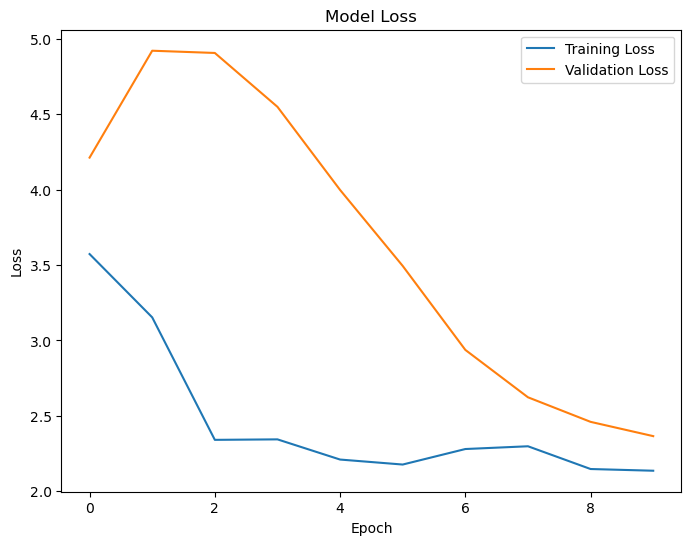

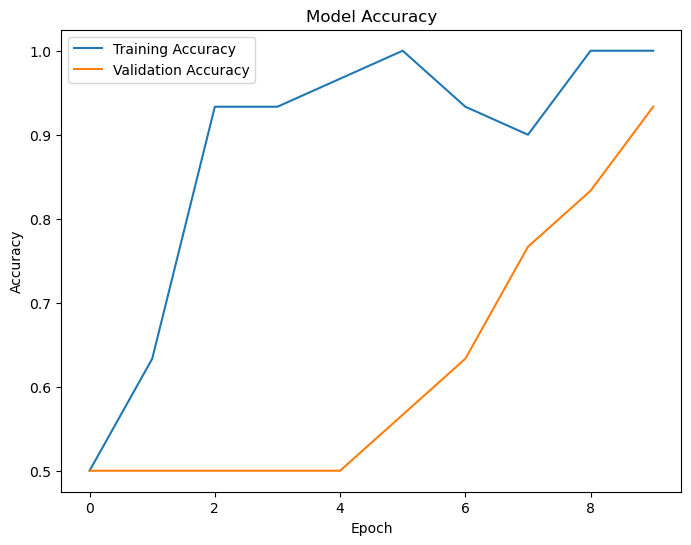

In [2]:
# Retrieve class names from class_indices
class_names = list(train_dataset.class_indices.keys())

# Create the model
model = define_model()

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall', 'F1Score'])

# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr  # Keep the initial learning rate for the first 5 epochs
    else:
        return lr * tf.math.exp(-0.1)  # Decrease the learning rate by a factor of e^(-0.1) after epoch 5

# Create a LearningRateScheduler callback
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Train the model with the learning rate scheduler callback
model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=10,
    validation_data=validation_dataset,
    validation_steps=len(validation_dataset),
    callbacks=[lr_scheduler_callback]  # Pass the lr_scheduler_callback here
)

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Feature Extraction and Classifier Training

In [3]:
# Extract features from the trained model
base_model = Model(inputs=model.layers[0].input, outputs=model.layers[-5].output)
# Flatten the features for random forest input
features = base_model.predict(validation_dataset)
features = np.reshape(features, (features.shape[0], -1))

# Create and train the random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=10)
rf_classifier.fit(features, validation_dataset.classes)

# Create and train the Support Vector Machine (SVM) classifier
svm_classifier = SVC(kernel='linear', C=1.0, probability=True)
svm_classifier.fit(features, validation_dataset.classes)

# Create and train the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1)
gb_classifier.fit(features, validation_dataset.classes)

# List of trained classifiers
trained_classifiers = [rf_classifier, svm_classifier, gb_classifier]  # Add other classifiers to this list

# Display the classifiers used
for idx, classifier in enumerate(trained_classifiers):
    print(f"Classifier {idx + 1}: {type(classifier).__name__}")


2/2 [==============================] - 1s 219ms/step
Classifier 1: RandomForestClassifier
Classifier 2: SVC
Classifier 3: GradientBoostingClassifier


# Visualizing Convolutional Filters

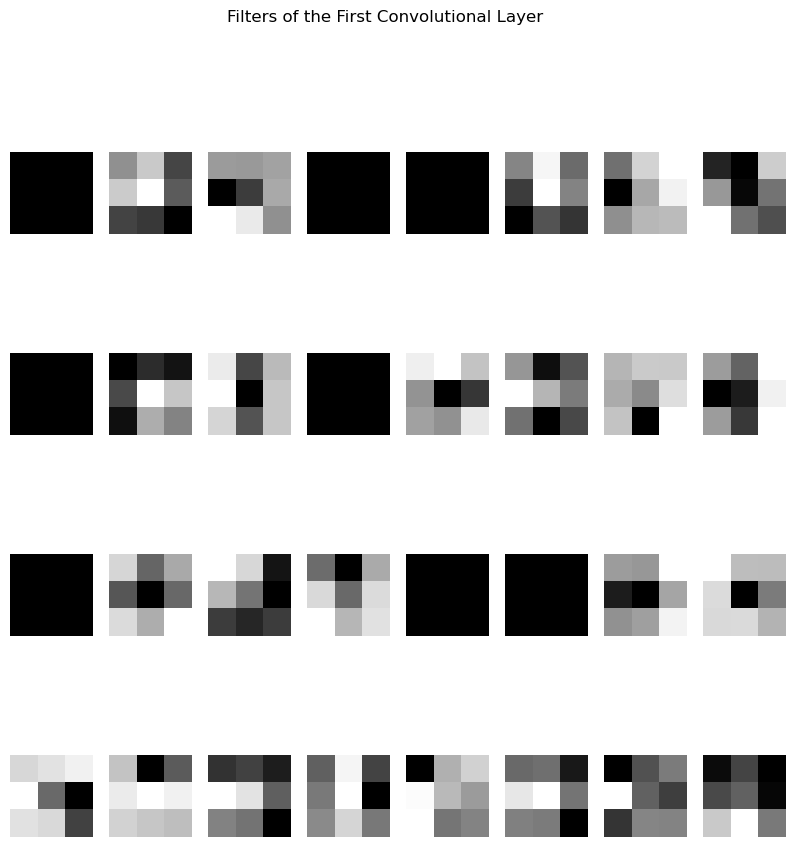

In [4]:
# Retrieve the weights of the first convolutional layer
conv1_weights = base_model.layers[1].get_weights()[0]
conv1_weights_normalized = (conv1_weights - np.min(conv1_weights)) / (np.max(conv1_weights) - np.min(conv1_weights))

# Visualize the filters of the first convolutional layer
plt.figure(figsize=(10, 10))
for i in range(conv1_weights_normalized.shape[-1]):
    plt.subplot(4, 8, i + 1)
    plt.imshow(conv1_weights_normalized[:, :, 0, i], cmap='gray')
    plt.axis('off')
plt.suptitle('Filters of the First Convolutional Layer')
plt.show()

# Prediction and Metrics

Image 0 is classified as: Early blight


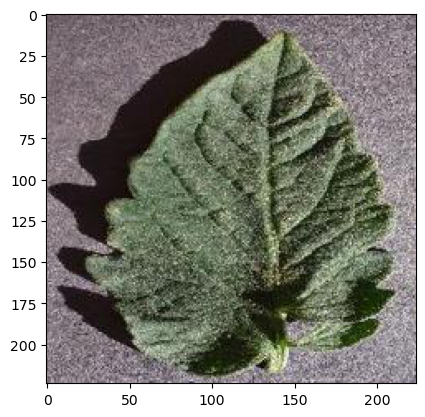

Image 1 is classified as: Early blight


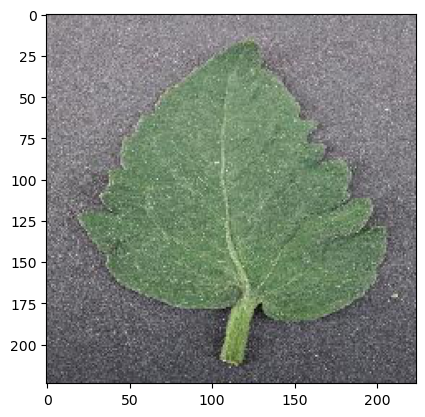

Image 2 is classified as: Early blight


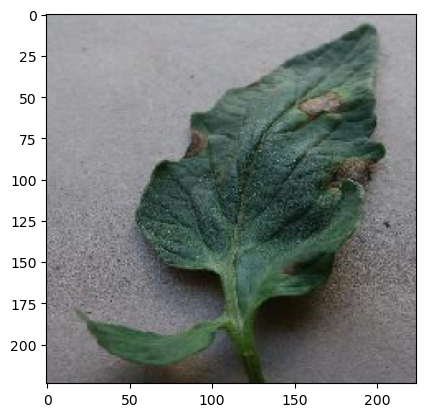

Image 3 is classified as: Early blight


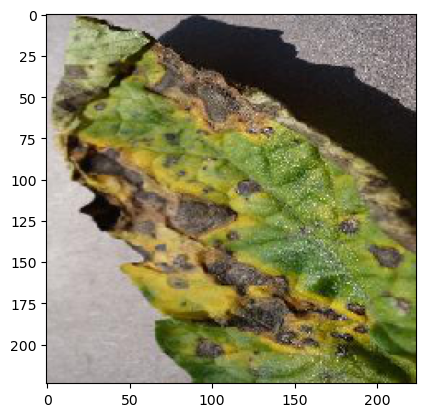

Image 4 is classified as: Early blight


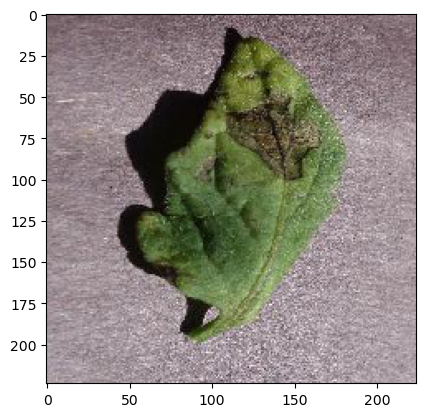

Image 5 is classified as: Early blight


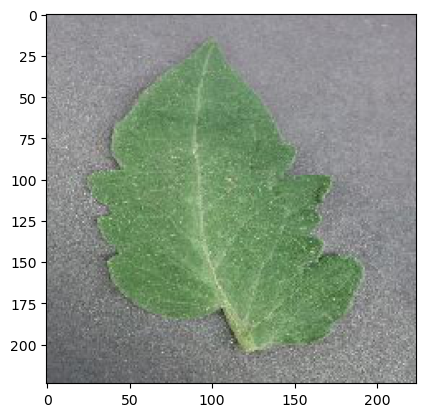

Image 6 is classified as: Early blight


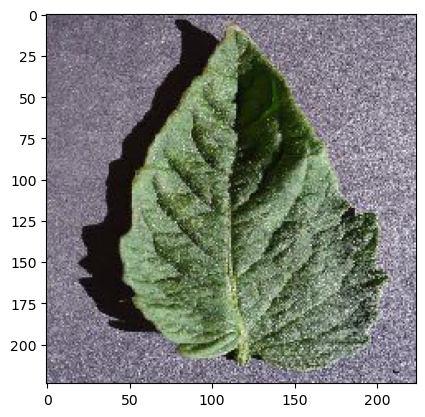

Image 7 is classified as: Early blight


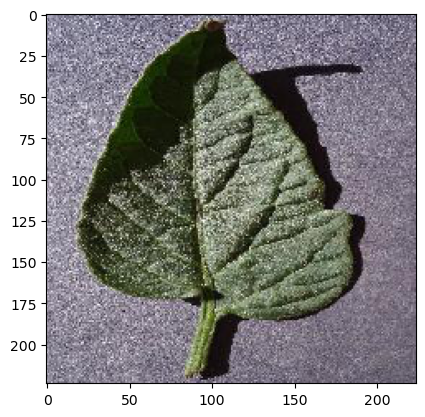

Image 8 is classified as: Early blight


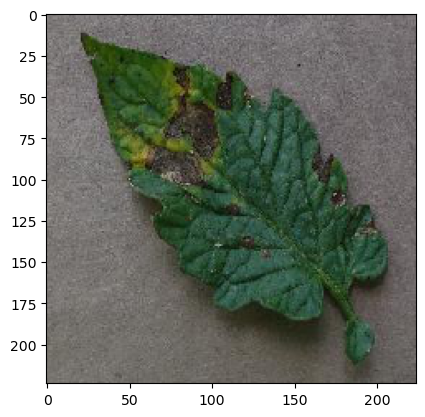

Image 9 is classified as: Early blight


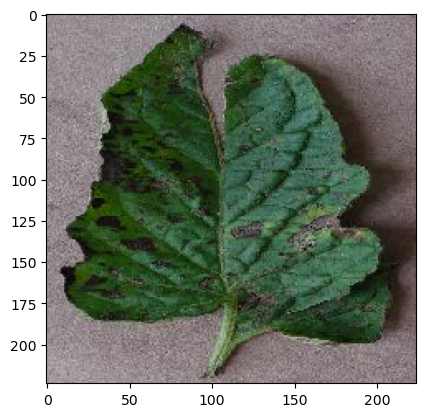

Image 10 is classified as: Early blight


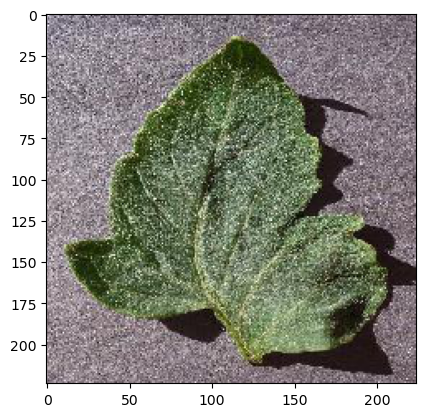

Image 11 is classified as: Early blight


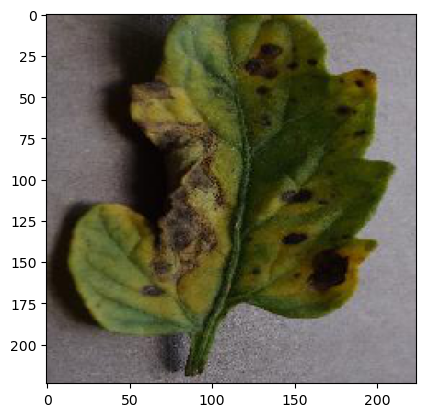

Image 12 is classified as: Early blight


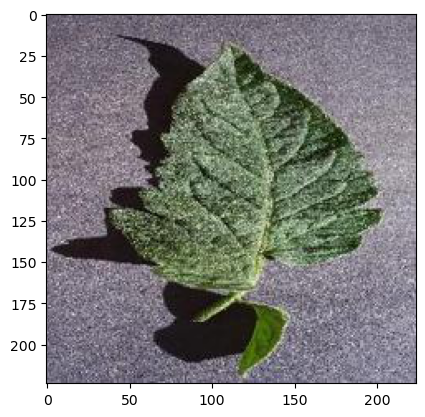

Image 13 is classified as: Early blight


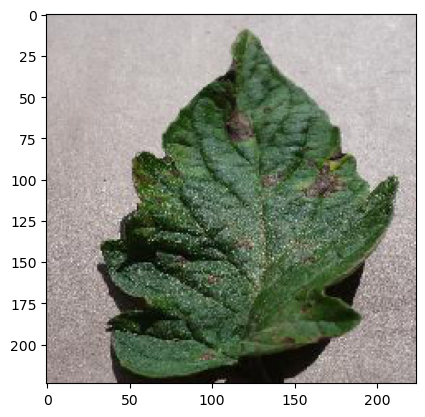

Image 14 is classified as: Early blight


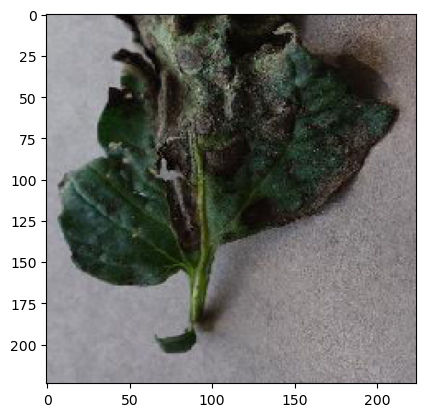

Image 15 is classified as: Healthy


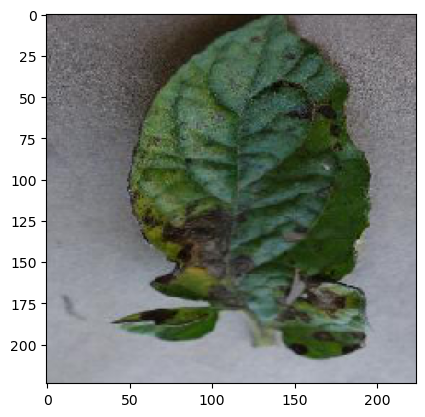

Image 16 is classified as: Healthy


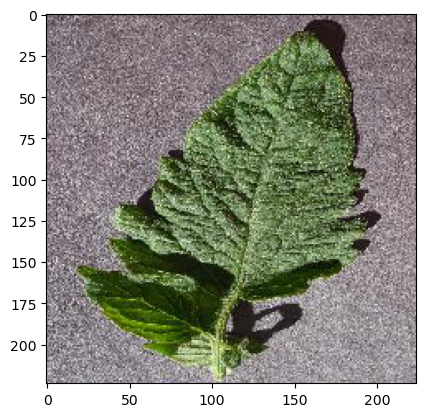

Image 17 is classified as: Healthy


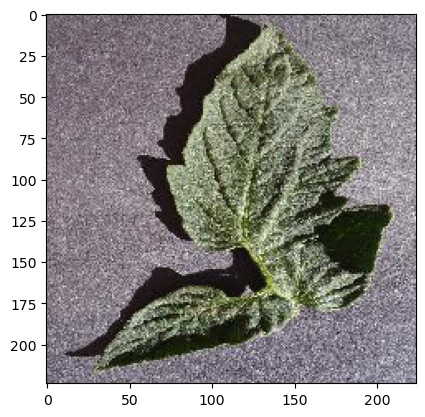

Image 18 is classified as: Healthy


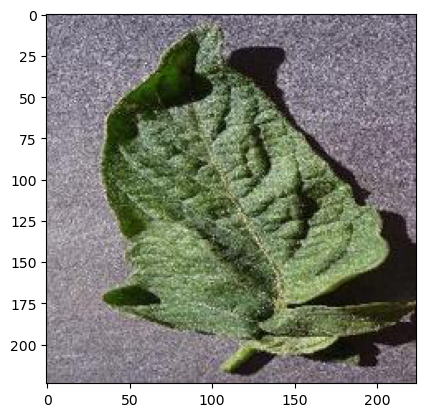

Image 19 is classified as: Healthy


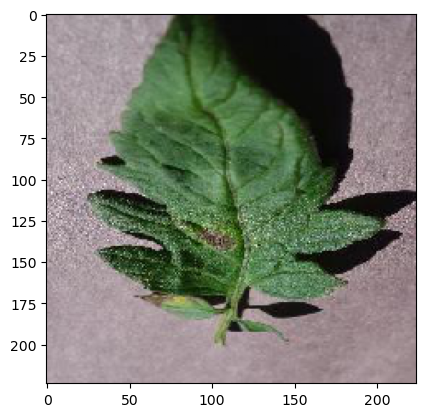

Image 20 is classified as: Healthy


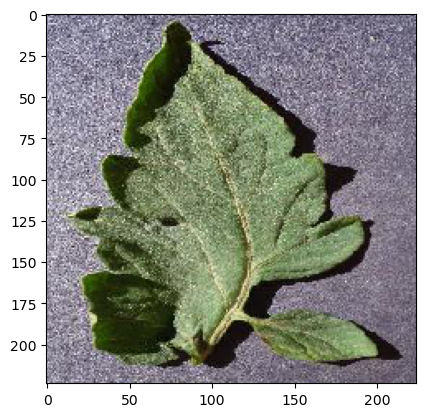

Image 21 is classified as: Healthy


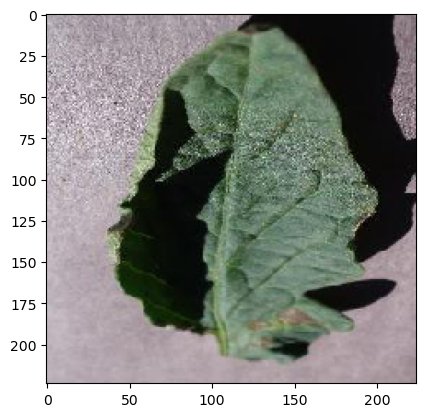

Image 8 is classified as: Early blight


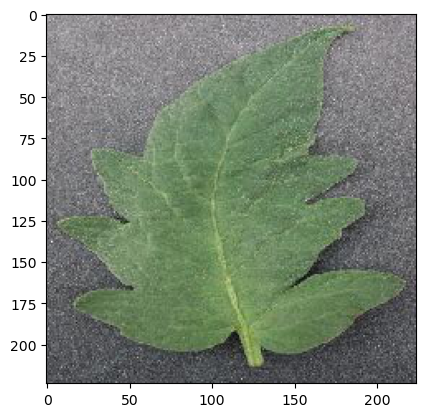

Image 9 is classified as: Early blight


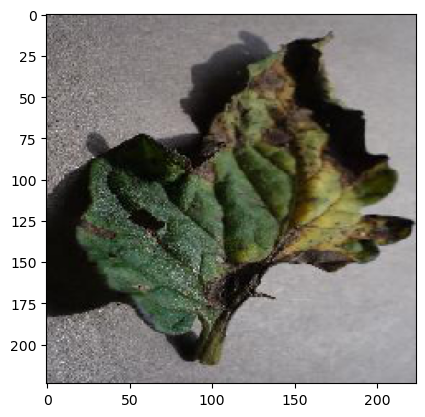

Image 10 is classified as: Early blight


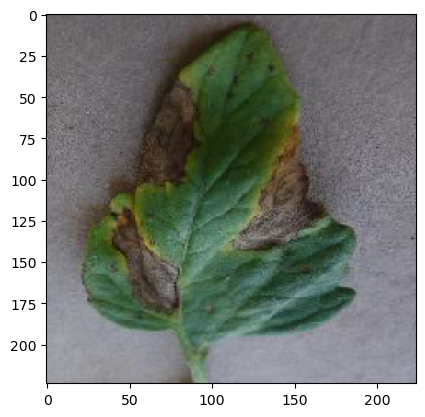

Image 11 is classified as: Early blight


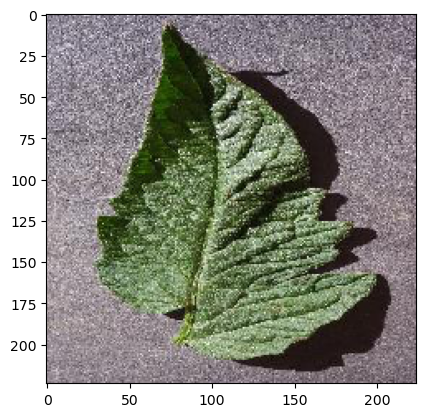

Image 12 is classified as: Early blight


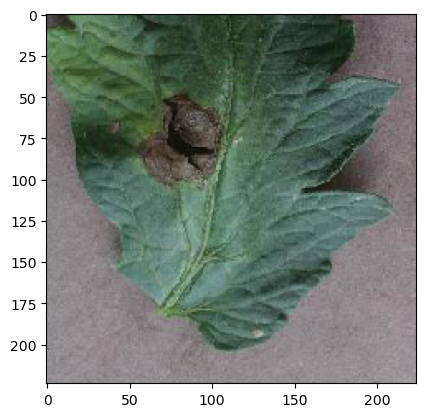

Image 13 is classified as: Early blight


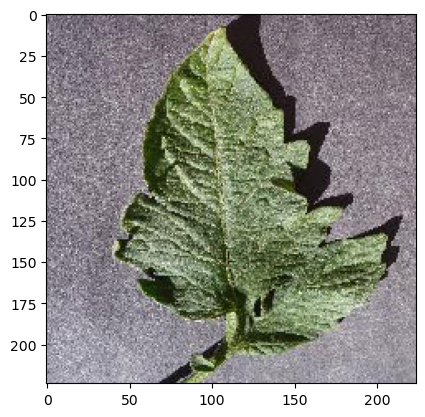

Image 14 is classified as: Early blight


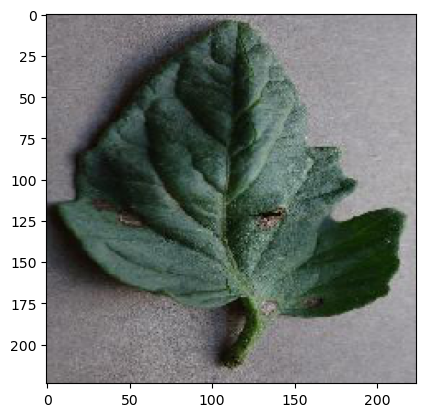

Image 15 is classified as: Early blight


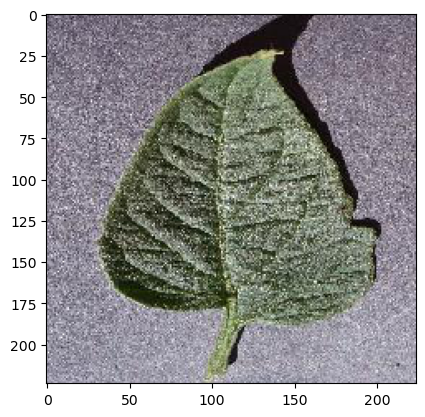

Early blight - True Positives: 4
Early blight - False Positives: 3
Early blight - True Negatives: 12
Early blight - False Negatives: 11
Healthy - True Positives: 12
Healthy - False Positives: 11
Healthy - True Negatives: 4
Healthy - False Negatives: 3


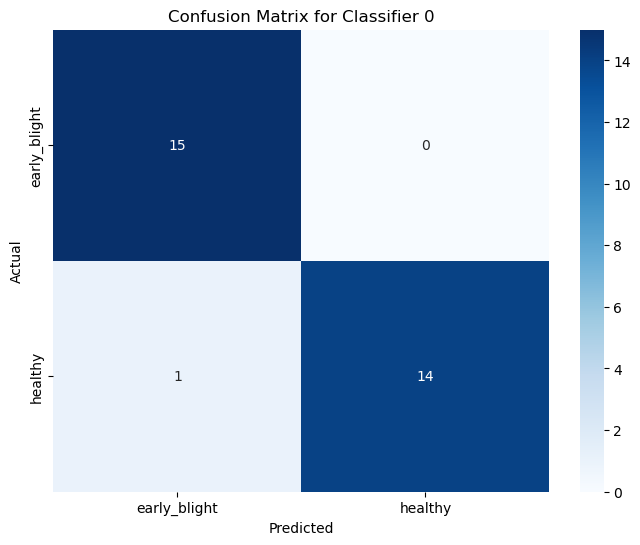

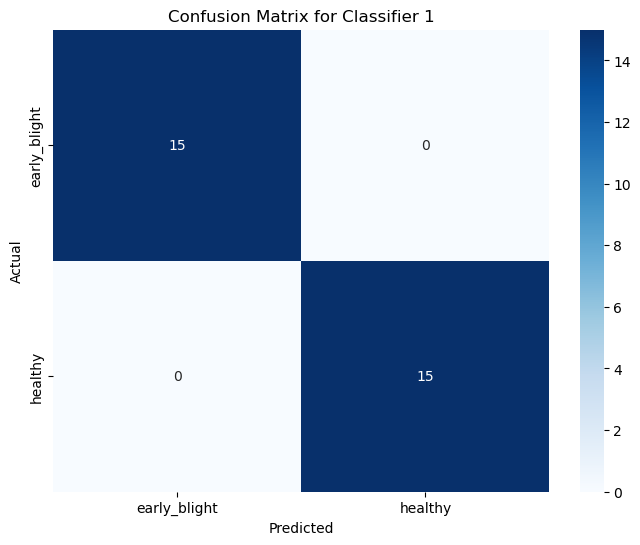

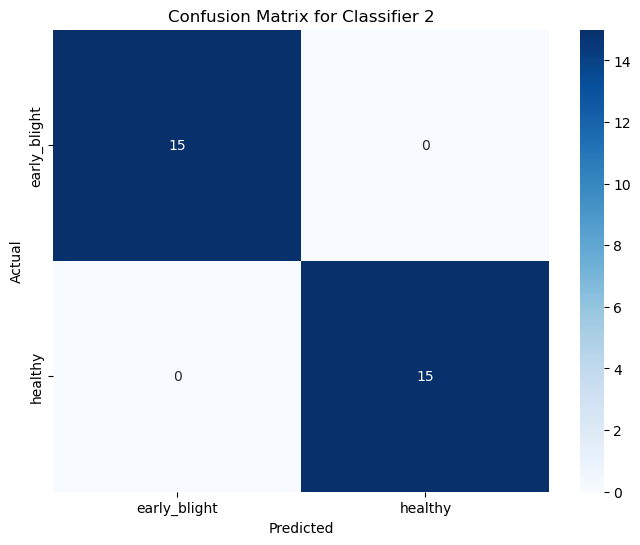

Classifier 1: RandomForestClassifier
Accuracy: 0.97
Precision: 1.00
Recall: 0.93
F1-Score: 0.97
Confusion Matrix:
[[15  0]
 [ 1 14]]
Classification Report:
              precision    recall  f1-score   support

early_blight       0.94      1.00      0.97        15
     healthy       1.00      0.93      0.97        15

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


---------------------------------------

Classifier 2: SVC
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
Confusion Matrix:
[[15  0]
 [ 0 15]]
Classification Report:
              precision    recall  f1-score   support

early_blight       1.00      1.00      1.00        15
     healthy       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


----------

In [5]:
# Function to indicate disease based on prediction
def indicate_disease(prediction):
    if prediction == 0:
        return "Early blight"
    elif prediction == 1:
        return "Healthy"
    else:
        raise ValueError("Unknown disease")

# Initialize counters
TP_early_blight = 0  # True Positives for Early blight
FP_early_blight = 0  # False Positives for Early blight
TN_early_blight = 0  # True Negatives for Early blight
FN_early_blight = 0  # False Negatives for Early blight

TP_healthy = 0  # True Positives for Healthy
FP_healthy = 0  # False Positives for Healthy
TN_healthy = 0  # True Negatives for Healthy
FN_healthy = 0  # False Negatives for Healthy

# Perform prediction and compute TP, FP, TN, FN
for i in range(len(validation_dataset)):
    images = validation_dataset[i][0]  # Get batch of images
    true_labels = validation_dataset[i][1]  # Get batch of true labels
    images_2d = np.reshape(images, (images.shape[0], -1))  # Reshape to 2D

    for j in range(len(true_labels)):
        true_label = true_labels[j]
        prediction = rf_classifier.predict(features[j:j+1, :])[0]

        if true_label == 1 and prediction == 1:  # Early blight - True Positive
            TP_early_blight += 1
        elif true_label == 0 and prediction == 1:  # Early blight - False Positive
            FP_early_blight += 1
        elif true_label == 1 and prediction == 0:  # Early blight - False Negative
            FN_early_blight += 1
        elif true_label == 0 and prediction == 0:
            TN_early_blight += 1

        if true_label == 0 and prediction == 0:  # Healthy - True Positive
            TP_healthy += 1
        elif true_label == 1 and prediction == 0:  # Healthy - False Positive
            FP_healthy += 1
        elif true_label == 0 and prediction == 1:  # Healthy - False Negative
            FN_healthy += 1
        elif true_label == 1 and prediction == 1:  # Healthy - True Negative
            TN_healthy += 1

        print(f'Image {(i * len(true_labels)) + j} is classified as: {indicate_disease(prediction)}')
        plt.imshow(images[j])
        plt.show()

# Display the computed metrics for Early blight
print("Early blight - True Positives:", TP_early_blight)
print("Early blight - False Positives:", FP_early_blight)
print("Early blight - True Negatives:", TN_early_blight)
print("Early blight - False Negatives:", FN_early_blight)

# Display the computed metrics for Healthy
print("Healthy - True Positives:", TP_healthy)
print("Healthy - False Positives:", FP_healthy)
print("Healthy - True Negatives:", TN_healthy)
print("Healthy - False Negatives:", FN_healthy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create a confusion matrix for each classifier
for idx, classifier in enumerate(trained_classifiers):
    predictions = classifier.predict(features)
    cm = confusion_matrix(validation_dataset.classes, predictions)
    
    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for Classifier {idx}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Initialize lists to store metrics for each classifier
metrics_rf = []
metrics_svm = []
metrics_gb = []

# Evaluate each classifier
for idx, classifier in enumerate(trained_classifiers):
    predictions = classifier.predict(features)
    accuracy = accuracy_score(validation_dataset.classes, predictions)
    precision = precision_score(validation_dataset.classes, predictions)
    recall = recall_score(validation_dataset.classes, predictions)
    f1 = f1_score(validation_dataset.classes, predictions)
    cm = confusion_matrix(validation_dataset.classes, predictions)
    
    # Print classifier type
    print(f"Classifier {idx + 1}: {type(classifier).__name__}")
    
    # Display evaluation metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    
    # Display confusion matrix
    print("Confusion Matrix:")
    print(cm)
    
    # Display classification report
    print("Classification Report:")
    print(classification_report(validation_dataset.classes, predictions, target_names=class_names))
    
    print("\n---------------------------------------\n")

    # Append metrics to respective lists
    if idx == 0:
        metrics_rf = [accuracy, precision, recall, f1]
    elif idx == 1:
        metrics_svm = [accuracy, precision, recall, f1]
    elif idx == 2:
        metrics_gb = [accuracy, precision, recall, f1]

# Display overall metrics
print("Overall Metrics:")
print("\nRandom Forest Classifier Metrics:", metrics_rf)
print("SVM Classifier Metrics:", metrics_svm)
print("Gradient Boosting Classifier Metrics:", metrics_gb)

# Calculate overall metrics
total_TP_early_blight = TP_early_blight
total_FP_early_blight = FP_early_blight
total_TN_early_blight = TN_early_blight
total_FN_early_blight = FN_early_blight

total_TP_healthy = TP_healthy
total_FP_healthy = FP_healthy
total_TN_healthy = TN_healthy
total_FN_healthy = FN_healthy

overall_accuracy_early_blight = (total_TP_early_blight + total_TN_early_blight) / (total_TP_early_blight + total_FP_early_blight + total_TN_early_blight + total_FN_early_blight)
overall_precision_early_blight = total_TP_early_blight / (total_TP_early_blight + total_FP_early_blight)
overall_recall_early_blight = total_TP_early_blight / (total_TP_early_blight + total_FN_early_blight)
overall_f1_score_early_blight = 2 * (overall_precision_early_blight * overall_recall_early_blight) / (overall_precision_early_blight + overall_recall_early_blight)

overall_accuracy_healthy = (total_TP_healthy + total_TN_healthy) / (total_TP_healthy + total_FP_healthy + total_TN_healthy + total_FN_healthy)
overall_precision_healthy = total_TP_healthy / (total_TP_healthy + total_FP_healthy)
overall_recall_healthy = total_TP_healthy / (total_TP_healthy + total_FN_healthy)
overall_f1_score_healthy = 2 * (overall_precision_healthy * overall_recall_healthy) / (overall_precision_healthy + overall_recall_healthy)

# Display overall metrics
print("\nOverall Metrics for Early Blight:")
print("Overall Accuracy:", overall_accuracy_early_blight)
print("Overall Precision:", overall_precision_early_blight)
print("Overall Recall:", overall_recall_early_blight)
print("Overall F1 Score:", overall_f1_score_early_blight)

print("\nOverall Metrics for Healthy:")
print("Overall Accuracy:", overall_accuracy_healthy)
print("Overall Precision:", overall_precision_healthy)
print("Overall Recall:", overall_recall_healthy)
print("Overall F1 Score:", overall_f1_score_healthy)

# Iterate over the validation dataset and calculate TP, FP, TN, FN for each class
for i in range(len(validation_dataset)):
    images = validation_dataset[i][0]  # Get batch of images
    true_labels = validation_dataset[i][1]  # Get batch of true labels

    for j in range(len(true_labels)):
        true_label = true_labels[j]
        prediction = rf_classifier.predict(features[j:j+1, :])[0]

        if true_label == 1 and prediction == 1:  # Early blight - True Positive
            TP_early_blight += 1
        elif true_label == 0 and prediction == 1:  # Early blight - False Positive
            FP_early_blight += 1
        elif true_label == 1 and prediction == 0:  # Early blight - False Negative
            FN_early_blight += 1
        elif true_label == 0 and prediction == 0:
            TN_early_blight += 1

        if true_label == 0 and prediction == 0:  # Healthy - True Positive
            TP_healthy += 1
        elif true_label == 1 and prediction == 0:  # Healthy - False Positive
            FP_healthy += 1
        elif true_label == 0 and prediction == 1:  # Healthy - False Negative
            FN_healthy += 1
        elif true_label == 1 and prediction == 1:  # Healthy - True Negative
            TN_healthy += 1

            # Calculate overall accuracy
accuracy = (TP_early_blight + TP_healthy + TN_early_blight + TN_healthy) / (TP_early_blight + FP_early_blight + TN_early_blight + FN_early_blight + TP_healthy + FP_healthy + TN_healthy + FN_healthy)

# Calculate overall precision
precision = (TP_early_blight + TP_healthy) / (TP_early_blight + FP_early_blight + TP_healthy + FP_healthy)

# Calculate overall recall
recall = (TP_early_blight + TP_healthy) / (TP_early_blight + FN_early_blight + TP_healthy + FN_healthy)

# Calculate overall F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the overall metrics
print("Overall accuracy:", accuracy)
print("Overall precision:", precision)
print("Overall recall:", recall)
print("Overall F1-score:", f1_score)

# Calculate accuracy for Early blight class
accuracy_early_blight = (TP_early_blight + TN_early_blight) / (TP_early_blight + FP_early_blight + TN_early_blight + FN_early_blight)

# Calculate accuracy for Healthy class
accuracy_healthy = (TP_healthy + TN_healthy) / (TP_healthy + FP_healthy + TN_healthy + FN_healthy)

# Calculate overall accuracy
overall_accuracy = (TP_early_blight + TP_healthy + TN_early_blight + TN_healthy) / (TP_early_blight + FP_early_blight + TN_early_blight + FN_early_blight + TP_healthy + FP_healthy + TN_healthy + FN_healthy)

# Print the accuracy for each class and the overall accuracy
print("Accuracy for Early blight class:", accuracy_early_blight)
print("Accuracy for Healthy class:", accuracy_healthy)
print("Overall accuracy:", overall_accuracy)


# t-SNE Visualization

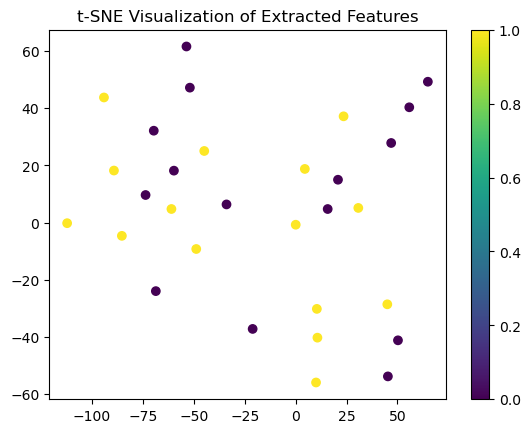

In [6]:
# Visualize the extracted features using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # Set perplexity to a lower value
tsne_features = tsne.fit_transform(features)

# Plot the t-SNE visualization
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=validation_dataset.classes, cmap='viridis')
plt.title('t-SNE Visualization of Extracted Features')
plt.colorbar()
plt.show() 